# I need to duplicate the fragility table a bunch of times for the training 

# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one hazards side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage
from collections import ChainMap
import re

from BNModel import BNModel


Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# Load Hazard Bins

In [3]:
with open("bin_definitions.json") as f:
    bin_defs_dict = json.load(f)

In [4]:
bin_defs_dict

{'earthquake': {'minimum': -5.553142870956083,
  'low': -3.266348397163859,
  'medium': -0.9795539233716353,
  'high': 1.3072405504205884},
 'liquefaction': {'zero': 0.0,
  'low': 7.377941176470587,
  'medium': 14.755882352941175,
  'high': 22.133823529411764},
 'tsunami': {'zero': 0,
  'low': 2.453279318446375,
  'medium': 4.90655863689275,
  'high': 7.359837955339124}}

# Methods for combining DS

In [5]:
damage_states_array = np.array((0,1,2,3))

fragility_array = np.array(('Shaking','Tsunami','Liquefaction','Landslide'))

In [6]:
rows = list(itertools.product(list(itertools.product(list(itertools.product(damage_states_array,damage_states_array)),damage_states_array)),damage_states_array))

df_fragilities = pd.DataFrame.from_dict(dict(ChainMap(*[{i:{
    'Shaking':x[0][0][0],
    'Tsunami':x[0][0][1],
    'Liquefaction':x[0][1],
    'Landslide':x[1]}} for i,x in zip(np.arange(0,len(rows),1),rows)]))).T

#### But we can put in percentages.. it doesn't have to be 100% into the one state ####

# Rules:
# Pick the max damage state. Start with this as the combined damage state.
# If there are multiple hazards of the same damage state, add one to the combined damage state
# Cap the damage state at 3

for index,row in df_fragilities.iterrows():
    comb_frag = np.max(row)
    # See how many hazards have the max damage state:
    number_with_max_damage = list(row).count(comb_frag)
    # If there are more than 2, add one to the combined damage state (unless your at max or no damage)
    if (number_with_max_damage>=2)&(comb_frag!=3)&(comb_frag!=0):
        comb_frag+=1
    
    # Add to the fragility
    df_fragilities.loc[index,'Combined'] = int(comb_frag)
    
# Rename the columns to include fragility
[df_fragilities.rename(columns={x:x+'Fragility'},inplace=True) for x in df_fragilities if x!='Combined']
    
df_fragilities

,ShakingFragility,TsunamiFragility,LiquefactionFragility,LandslideFragility,Combined
255,3,3,3,3,3.0
254,3,3,3,2,3.0
253,3,3,3,1,3.0
252,3,3,3,0,3.0
251,3,3,2,3,3.0
...,...,...,...,...,...
4,0,0,1,0,1.0
3,0,0,0,3,3.0
2,0,0,0,2,2.0
1,0,0,0,1,1.0


In [7]:
# Replace the integers with strings 
df_fragilities = df_fragilities.replace(0,'DS0')
df_fragilities = df_fragilities.replace(1,'DS1')
df_fragilities = df_fragilities.replace(2,'DS2')
df_fragilities = df_fragilities.replace(3,'DS3')


In [8]:
df_fragilities.reset_index(drop=True,inplace=True)

# Create a BN using this table

In [9]:
frag_data_dict = {k:np.array(df_fragilities[k]) for k in list(df_fragilities)}

In [10]:
frag_data_dict

{'ShakingFragility': array(['DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3', 'DS3',
        'DS3', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2',
        'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 'DS2', 

In [11]:
frag_file_label = 'fragility'

#### Don't include spaces in bin names. if no discretisation, just leave out that key
frag_model_dict = {
    'variables':{
        'ShakingFragility':{
            'label':'ShakingFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3']
        },
        'TsunamiFragility':{
            'label':'TsunamiFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3']
        },
        'LiquefactionFragility':{
            'label':'LiquefactionFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3']
        },
        'LandslideFragility':{
            'label':'LandslideFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3']
        },
        'Combined':{
            'label':'Combined',
            'child_nodes':[],
            'bins':['DS0','DS1','DS2','DS3']
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

In [12]:
df_fragilities

,ShakingFragility,TsunamiFragility,LiquefactionFragility,LandslideFragility,Combined
0,DS3,DS3,DS3,DS3,DS3
1,DS3,DS3,DS3,DS2,DS3
2,DS3,DS3,DS3,DS1,DS3
3,DS3,DS3,DS3,DS0,DS3
4,DS3,DS3,DS2,DS3,DS3
...,...,...,...,...,...
251,DS0,DS0,DS1,DS0,DS1
252,DS0,DS0,DS0,DS3,DS3
253,DS0,DS0,DS0,DS2,DS2
254,DS0,DS0,DS0,DS1,DS1


In [13]:
frag_model_dict = BNModel().bootstrap_data(frag_model_dict,frag_data_dict,df_fragilities)

In [14]:
frag_model_dict = BNModel().discretiser(frag_model_dict,[])

ShakingFragility
TsunamiFragility
LiquefactionFragility
LandslideFragility
Combined


In [15]:
BNModel().save_dataset(frag_model_dict,frag_file_label)

In [16]:
frag_model_dict = BNModel().create_SM(frag_model_dict,frag_file_label)

In [17]:
# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)

# Creating Dummy fragility functions

## Earthquakes

In [47]:
bins = bin_defs_dict['earthquake']
earthquake_max = 2*bins['high']-bins['medium']
earthquake_diff = bins['high']-bins['medium']

In [48]:
earthquake_diff

2.2867944737922237

/tmp/ipykernel_277/1850619962.py:30: RuntimeWarning: divide by zero encountered in log
  P_ds3 = [(np.log(im)-mu_ds3)/sigma_ds3 for im in IM]
/tmp/ipykernel_277/1850619962.py:32: RuntimeWarning: invalid value encountered in true_divide
  P_ds3 = P_ds3/np.max(P_ds3)


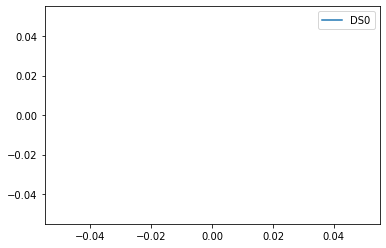

In [52]:
ax = plt.subplot2grid((1,1),(0,0))

# Get max mean pga
mu_ds0 = bins['minimum']
mu_ds1 = 2*earthquake_diff+bins['minimum']
mu_ds2 = 3*earthquake_diff+bins['minimum']
mu_ds3 = 4*earthquake_diff+bins['minimum']

sigma_ds0 = 0.00000001
sigma_ds1 = 1
sigma_ds2 = 1
sigma_ds3 = 1

IM = np.arange(bins['minimum'],earthquake_max,(earthquake_max-bins['minimum'])/1000)

P_ds0 = [1/(sigma_ds0*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds0)/sigma_ds0)**2) for im in IM]
P_ds0 = np.cumsum(P_ds0)
P_ds0 = P_ds0/np.max(P_ds0)

P_ds1 = [1/(sigma_ds1*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds1)/sigma_ds1)**2) for im in IM]
P_ds1 = np.cumsum(P_ds1)
P_ds1 = P_ds1/np.max(P_ds1)

P_ds2 = [1/(sigma_ds2*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds2)/sigma_ds2)**2) for im in IM]
P_ds2 = np.cumsum(P_ds2)
P_ds2 = P_ds2/np.max(P_ds2)

# P_ds3 = [1/(sigma_ds3*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds3)/sigma_ds3)**2) for im in IM]
IM = np.arange(0,1,0.1)
P_ds3 = [(np.log(im)-mu_ds3)/sigma_ds3 for im in IM]
P_ds3 = np.cumsum(P_ds3)
P_ds3 = P_ds3/np.max(P_ds3)

# l0 = plt.plot(IM,P_ds0)
# l1 = plt.plot(IM,P_ds1)
# l2 = plt.plot(IM,P_ds2)
l3 = plt.plot(IM,P_ds3)

# ax.plot([bins['low'],bins['low']],[0,1],ls='--',c='k')
# ax.plot([bins['medium'],bins['medium']],[0,1],ls='--',c='k')
# ax.plot([bins['high'],bins['high']],[0,1],ls='--',c='k')

ax.legend(['DS0','DS1','DS2','DS3'])

# plt.plot(IM,P_ds0)
# plt.plot(IM,P_ds1)
# plt.plot(IM,P_ds2)
# plt.plot(IM,P_ds3)


In [53]:
[(np.log(im)-mu_ds3)/sigma_ds3 for im in IM]

/tmp/ipykernel_277/1658130550.py:1: RuntimeWarning: divide by zero encountered in log
  [(np.log(im)-mu_ds3)/sigma_ds3 for im in IM]


[-inf,
 -5.896620117206858,
 -5.203472936646913,
 -4.798007828538748,
 -4.510325756086967,
 -4.2871822047727575,
 -4.104860647978803,
 -3.9507099681515445,
 -3.8171785755270218,
 -3.6993955398706384]

In [50]:
IM

array([-5.55314287e+00, -5.54399569e+00, -5.53484852e+00, -5.52570134e+00,
       -5.51655416e+00, -5.50740698e+00, -5.49825980e+00, -5.48911263e+00,
       -5.47996545e+00, -5.47081827e+00, -5.46167109e+00, -5.45252391e+00,
       -5.44337674e+00, -5.43422956e+00, -5.42508238e+00, -5.41593520e+00,
       -5.40678802e+00, -5.39764085e+00, -5.38849367e+00, -5.37934649e+00,
       -5.37019931e+00, -5.36105214e+00, -5.35190496e+00, -5.34275778e+00,
       -5.33361060e+00, -5.32446342e+00, -5.31531625e+00, -5.30616907e+00,
       -5.29702189e+00, -5.28787471e+00, -5.27872753e+00, -5.26958036e+00,
       -5.26043318e+00, -5.25128600e+00, -5.24213882e+00, -5.23299164e+00,
       -5.22384447e+00, -5.21469729e+00, -5.20555011e+00, -5.19640293e+00,
       -5.18725576e+00, -5.17810858e+00, -5.16896140e+00, -5.15981422e+00,
       -5.15066704e+00, -5.14151987e+00, -5.13237269e+00, -5.12322551e+00,
       -5.11407833e+00, -5.10493115e+00, -5.09578398e+00, -5.08663680e+00,
       -5.07748962e+00, -

In [21]:
df_ds_shaking = pd.DataFrame.from_dict({"DS0":P_ds0,"DS1":P_ds1,"DS2":P_ds2,"DS3":P_ds3})
df_ds_shaking.index = IM

In [22]:
df_ds_shaking["DS2"] = df_ds_shaking.DS2-df_ds_shaking.DS3
df_ds_shaking["DS1"] = df_ds_shaking.DS1-df_ds_shaking.DS2-df_ds_shaking.DS3
df_ds_shaking["DS0"] = df_ds_shaking.DS0-df_ds_shaking.DS1-df_ds_shaking.DS2-df_ds_shaking.DS3

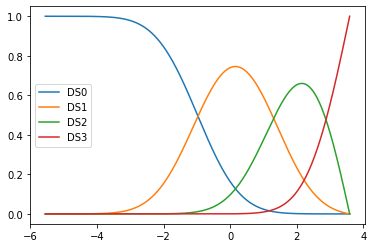

In [23]:
l0 = plt.plot(df_ds_shaking.DS0)
l1 = plt.plot(df_ds_shaking.DS1)
l2 = plt.plot(df_ds_shaking.DS2)
l3 = plt.plot(df_ds_shaking.DS3)

plt.legend(['DS0','DS1','DS2','DS3'])


In [24]:
df_ds_shaking

,DS0,DS1,DS2,DS3
-5.553143,9.999999e-01,1.047066e-07,2.223826e-13,4.964983e-21
-5.543996,9.999998e-01,2.138820e-07,4.591576e-13,1.036304e-20
-5.534849,9.999997e-01,3.277074e-07,7.112355e-13,1.623145e-20
-5.525701,9.999996e-01,4.463709e-07,9.795828e-13,2.261067e-20
-5.516554,9.999994e-01,5.700678e-07,1.265226e-12,2.954458e-20
...,...,...,...,...
3.548299,4.653622e-07,1.137949e-03,2.815289e-02,9.707087e-01
3.557446,3.416650e-07,8.445811e-04,2.112616e-02,9.780289e-01
3.566593,2.230013e-07,5.571989e-04,1.409129e-02,9.853513e-01
3.575741,1.091756e-07,2.757044e-04,7.049003e-03,9.926752e-01


## Tsunami

In [25]:
bins = bin_defs_dict['tsunami']
tsunami_max = 2*bins['high']-bins['medium']
tsunami_max

9.813117273785497

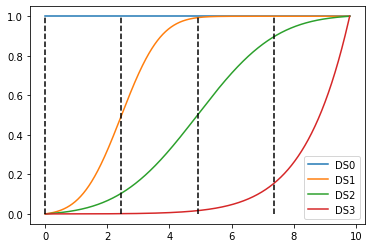

In [26]:
ax = plt.subplot2grid((1,1),(0,0))

# Get max mean pga
mu_ds0 = 0.0000001#max_pga/4
mu_ds1 = tsunami_max/4
mu_ds2 = 2*tsunami_max/4
mu_ds3 = tsunami_max*2

sigma_ds0 = 0.00000001
sigma_ds1 = 1
sigma_ds2 = 2
sigma_ds3 = 4

IM = np.arange(0,tsunami_max,(tsunami_max-0)/1000)

P_ds0 = [1/(sigma_ds0*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds0)/sigma_ds0)**2) for im in IM]
P_ds0 = np.cumsum(P_ds0)
P_ds0 = P_ds0/np.max(P_ds0)

P_ds1 = [1/(sigma_ds1*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds1)/sigma_ds1)**2) for im in IM]
P_ds1 = np.cumsum(P_ds1)
P_ds1 = P_ds1/np.max(P_ds1)

P_ds2 = [1/(sigma_ds2*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds2)/sigma_ds2)**2) for im in IM]
P_ds2 = np.cumsum(P_ds2)
P_ds2 = P_ds2/np.max(P_ds2)

P_ds3 = [1/(sigma_ds3*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds3)/sigma_ds3)**2) for im in IM]
P_ds3 = np.cumsum(P_ds3)
P_ds3 = P_ds3/np.max(P_ds3)

l0 = ax.plot(IM,P_ds0)
l1 = ax.plot(IM,P_ds1)
l2 = ax.plot(IM,P_ds2)
l3 = ax.plot(IM,P_ds3)

ax.plot([bins['zero'],bins['zero']],[0,1],ls='--',c='k')
ax.plot([bins['low'],bins['low']],[0,1],ls='--',c='k')
ax.plot([bins['medium'],bins['medium']],[0,1],ls='--',c='k')
ax.plot([bins['high'],bins['high']],[0,1],ls='--',c='k')

ax.legend(['DS0','DS1','DS2','DS3'])

# plt.plot(IM,P_ds0)
# plt.plot(IM,P_ds1)
# plt.plot(IM,P_ds2)
# plt.plot(IM,P_ds3)


In [27]:
df_ds_tsunami = pd.DataFrame.from_dict({"DS0":P_ds0,"DS1":P_ds1,"DS2":P_ds2,"DS3":P_ds3})
df_ds_tsunami.index = IM

In [28]:
df_ds_tsunami["DS2"] = df_ds_tsunami.DS2-df_ds_tsunami.DS3
df_ds_tsunami["DS1"] = df_ds_tsunami.DS1-df_ds_tsunami.DS2-df_ds_tsunami.DS3
df_ds_tsunami["DS0"] = df_ds_tsunami.DS0-df_ds_tsunami.DS1-df_ds_tsunami.DS2-df_ds_tsunami.DS3

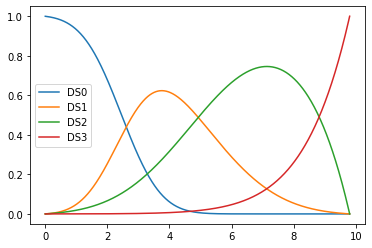

In [29]:
l0 = plt.plot(df_ds_tsunami.DS0)
l1 = plt.plot(df_ds_tsunami.DS1)
l2 = plt.plot(df_ds_tsunami.DS2)
l3 = plt.plot(df_ds_tsunami.DS3)

plt.legend(['DS0','DS1','DS2','DS3'])


In [30]:
df_ds_tsunami

,DS0,DS1,DS2,DS3
0.000000,9.998055e-01,0.000097,0.000097,8.214558e-07
0.009813,9.996063e-01,0.000197,0.000195,1.652857e-06
0.019626,9.994023e-01,0.000300,0.000295,2.494318e-06
0.029439,9.991934e-01,0.000408,0.000396,3.345957e-06
0.039252,9.989794e-01,0.000519,0.000497,4.207891e-06
...,...,...,...,...
9.764052,3.275158e-14,0.000404,0.026565,9.730311e-01
9.773865,2.364775e-14,0.000301,0.019987,9.797124e-01
9.783678,1.521006e-14,0.000199,0.013366,9.864342e-01
9.793491,7.327472e-15,0.000099,0.006704,9.931967e-01


## Liquefaction

In [31]:
bins = bin_defs_dict['liquefaction']
liquefaction_max = 2*bins['high']-bins['medium']
liquefaction_max

29.511764705882353

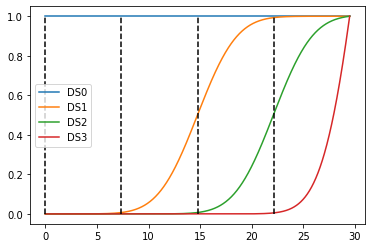

In [32]:
ax = plt.subplot2grid((1,1),(0,0))

# Get max mean pga
mu_ds0 = 0.0000001#max_pga/4
mu_ds1 = 2*liquefaction_max/4
mu_ds2 = 3*liquefaction_max/4
mu_ds3 = liquefaction_max*1.05

sigma_ds0 = 0.00000001
sigma_ds1 = 3
sigma_ds2 = 3
sigma_ds3 = 3

IM = np.arange(0,liquefaction_max,(liquefaction_max-0)/1000)

P_ds0 = [1/(sigma_ds0*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds0)/sigma_ds0)**2) for im in IM]
P_ds0 = np.cumsum(P_ds0)
P_ds0 = P_ds0/np.max(P_ds0)

P_ds1 = [1/(sigma_ds1*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds1)/sigma_ds1)**2) for im in IM]
P_ds1 = np.cumsum(P_ds1)
P_ds1 = P_ds1/np.max(P_ds1)

P_ds2 = [1/(sigma_ds2*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds2)/sigma_ds2)**2) for im in IM]
P_ds2 = np.cumsum(P_ds2)
P_ds2 = P_ds2/np.max(P_ds2)

P_ds3 = [1/(sigma_ds3*(2*np.pi)**0.5)*np.exp(-.5*((im-mu_ds3)/sigma_ds3)**2) for im in IM]
P_ds3 = np.cumsum(P_ds3)
P_ds3 = P_ds3/np.max(P_ds3)

l0 = ax.plot(IM,P_ds0)
l1 = ax.plot(IM,P_ds1)
l2 = ax.plot(IM,P_ds2)
l3 = ax.plot(IM,P_ds3)

ax.plot([bins['zero'],bins['zero']],[0,1],ls='--',c='k')
ax.plot([bins['low'],bins['low']],[0,1],ls='--',c='k')
ax.plot([bins['medium'],bins['medium']],[0,1],ls='--',c='k')
ax.plot([bins['high'],bins['high']],[0,1],ls='--',c='k')

ax.legend(['DS0','DS1','DS2','DS3'])

# plt.plot(IM,P_ds0)
# plt.plot(IM,P_ds1)
# plt.plot(IM,P_ds2)
# plt.plot(IM,P_ds3)


In [33]:
df_ds_liquefaction = pd.DataFrame.from_dict({"DS0":P_ds0,"DS1":P_ds1,"DS2":P_ds2,"DS3":P_ds3})
df_ds_liquefaction.index = IM

In [34]:
df_ds_liquefaction["DS2"] = df_ds_liquefaction.DS2-df_ds_liquefaction.DS3
df_ds_liquefaction["DS1"] = df_ds_liquefaction.DS1-df_ds_liquefaction.DS2-df_ds_liquefaction.DS3
df_ds_liquefaction["DS0"] = df_ds_liquefaction.DS0-df_ds_liquefaction.DS1-df_ds_liquefaction.DS2-df_ds_liquefaction.DS3

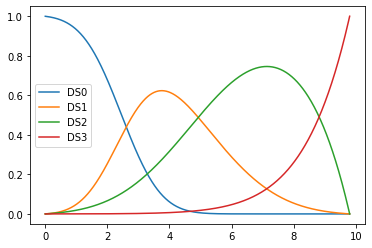

In [35]:
l0 = plt.plot(df_ds_tsunami.DS0)
l1 = plt.plot(df_ds_tsunami.DS1)
l2 = plt.plot(df_ds_tsunami.DS2)
l3 = plt.plot(df_ds_tsunami.DS3)

plt.legend(['DS0','DS1','DS2','DS3'])


In [36]:
df_ds_liquefaction

,DS0,DS1,DS2,DS3
0.000000,1.000000e+00,2.189594e-08,5.979472e-15,8.615860e-26
0.029512,1.000000e+00,4.487627e-08,1.240875e-14,1.815274e-25
0.059024,9.999999e-01,6.899237e-08,1.932101e-14,2.870808e-25
0.088535,9.999999e-01,9.429790e-08,2.675180e-14,4.038950e-25
0.118047,9.999999e-01,1.208490e-07,3.473926e-14,5.331589e-25
...,...,...,...,...
29.364206,9.895307e-08,8.161624e-04,4.354515e-02,9.556386e-01
29.393718,7.240198e-08,6.047450e-04,3.275115e-02,9.666440e-01
29.423229,4.709644e-08,3.983105e-04,2.189503e-02,9.777066e-01
29.452741,2.298034e-08,1.967611e-04,1.097769e-02,9.888255e-01


## Landslide

In [37]:
# It's binary, so just make up two rows
ds_landslide_dict = {
    '0':{
        'DS0':0.997,
        'DS1':0.001,
        'DS2':0.001,
        'DS3':0.001
    },
    '1':{
        'DS0':0.05,
        'DS1':0.15,
        'DS2':0.6,
        'DS3':0.2
    }
}

In [38]:
df_ds_landslide = pd.DataFrame.from_dict(ds_landslide_dict,orient='index')

## Find the prior distribution for this hazard

## Define Low, Medium and High

In [39]:
# ## Make up the definition of low, medium and high
# len_pga = len(list(df_ds_shaking.index))
# pga_low = list(df_ds_shaking.index)[int((len_pga-1)/4)]
# pga_medium = list(df_ds_shaking.index)[int(2*(len_pga-1)/4)]
# pga_high = list(df_ds_shaking.index)[int(3*(len_pga-1)/4)]


In [40]:
earthquake_low = min(list(df_ds_shaking.index), key=lambda x:abs(x-bin_defs_dict['earthquake']['low']))
earthquake_medium = min(list(df_ds_shaking.index), key=lambda x:abs(x-bin_defs_dict['earthquake']['medium']))
earthquake_high = min(list(df_ds_shaking.index), key=lambda x:abs(x-bin_defs_dict['earthquake']['high']))

tsunami_zero = min(list(df_ds_tsunami.index), key=lambda x:abs(x-bin_defs_dict['tsunami']['zero']))
tsunami_low = min(list(df_ds_tsunami.index), key=lambda x:abs(x-bin_defs_dict['tsunami']['low']))
tsunami_medium = min(list(df_ds_tsunami.index), key=lambda x:abs(x-bin_defs_dict['tsunami']['medium']))
tsunami_high = min(list(df_ds_tsunami.index), key=lambda x:abs(x-bin_defs_dict['tsunami']['high']))

liquefaction_zero = min(list(df_ds_liquefaction.index), key=lambda x:abs(x-bin_defs_dict['liquefaction']['zero']))
liquefaction_low = min(list(df_ds_liquefaction.index), key=lambda x:abs(x-bin_defs_dict['liquefaction']['low']))
liquefaction_medium = min(list(df_ds_liquefaction.index), key=lambda x:abs(x-bin_defs_dict['liquefaction']['medium']))
liquefaction_high = min(list(df_ds_liquefaction.index), key=lambda x:abs(x-bin_defs_dict['liquefaction']['high']))

landslide_no = '0'
landslide_yes = '1'


# Set Conditional Prob Tables

In [41]:
net = frag_model_dict['model'][0]['net']

In [42]:
list_of_nodes = net.get_all_nodes()
list_of_nodes.pop(net.get_node('Combined'))
list_of_nodes

[0, 1, 2, 3]

In [43]:
for node_handle in list_of_nodes:
    # Get a single fragility node
    child_node_name = net.get_node_id(node_handle)
    # Create a new node for the hazard
    new_node_name = re.sub('Fragility','',child_node_name)
    net.add_node(pysmile.NodeType.CPT,new_node_name)
    # Add the outcomes
    if new_node_name=='Shaking':
        for outcome in ['low','medium','high']:
            net.add_outcome(new_node_name,outcome)
    elif new_node_name=='Landslide':
        for outcome in ['no','yes']:
            net.add_outcome(new_node_name,outcome)
    else:
        for outcome in ['zero','low','medium','high']:
            net.add_outcome(new_node_name,outcome)
    # Delete the premade states
    net.delete_outcome(new_node_name,'State0')
    net.delete_outcome(new_node_name,'State1')
    # Create connection between the hazard and fragility functions
    net.add_arc(new_node_name,child_node_name)
    print(new_node_name)
    print(child_node_name)
    # Set the values of the conditional probability table for the fragility node
    if new_node_name=='Shaking':
        cpt_value = \
            list(df_ds_shaking[df_ds_shaking.index==earthquake_low].T[earthquake_low])+\
            list(df_ds_shaking[df_ds_shaking.index==earthquake_medium].T[earthquake_medium])+\
            list(df_ds_shaking[df_ds_shaking.index==earthquake_high].T[earthquake_high])
    elif new_node_name=='Landslide':
        cpt_value = \
            list(df_ds_landslide[df_ds_landslide.index==landslide_no].T[landslide_no])+\
            list(df_ds_landslide[df_ds_landslide.index==landslide_yes].T[landslide_yes])
    elif new_node_name=='Tsunami':
        cpt_value = \
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_zero].T[tsunami_zero])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_low].T[tsunami_low])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_medium].T[tsunami_medium])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_high].T[tsunami_high])
    elif new_node_name=='Liquefaction':
        cpt_value = \
            list(df_ds_liquefaction[df_ds_liquefaction.index==liquefaction_zero].T[liquefaction_zero])+\
            list(df_ds_liquefaction[df_ds_liquefaction.index==liquefaction_low].T[liquefaction_low])+\
            list(df_ds_liquefaction[df_ds_liquefaction.index==liquefaction_medium].T[liquefaction_medium])+\
            list(df_ds_liquefaction[df_ds_liquefaction.index==liquefaction_high].T[liquefaction_high])
    net.set_node_definition(child_node_name,cpt_value)
    

Shaking
ShakingFragility
Tsunami
TsunamiFragility
Liquefaction
LiquefactionFragility
Landslide
LandslideFragility


In [44]:
dir(net)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add_arc',
 'add_cost_arc',
 'add_node',
 'add_outcome',
 'add_submodel',
 'add_temporal_arc',
 'annealed_map',
 'clear_all_evidence',
 'clear_all_targets',
 'clear_evidence',
 'clear_temporal_evidence',
 'delete_arc',
 'delete_cost_arc',
 'delete_node',
 'delete_outcome',
 'delete_submodel',
 'delete_temporal_arc',
 'distributed_helper_em',
 'get_all_node_ids',
 'get_all_nodes',
 'get_bayesian_algorithm',
 'get_child_ids',
 'get_children',
 'get_cont_evidence',
 'get_controlled_value',
 'get_controlled_value_id',
 'get_cost_child_ids',
 'get_cost_children',
 'get_cost_parent_ids',
 'get_cost_parents',
 'get_de_morgan_pa

In [45]:
net.get_node_value('Combined')

SMILEException: SMILE Error Occured in: Network.GetValue
ErrNo=1

In [ ]:
list(df_ds_liquefaction[df_ds_liquefaction.index==liquefaction_zero].T[liquefaction_zero])

In [ ]:
np.sum(cpt_value)/3

In [ ]:
frag_model_dict['model'][0]['net'].get_node_definition('Landslide')

In [ ]:
frag_model_dict['model'][0]['net'].get_node('Tsunami')

In [ ]:
net.write_file("test.xdsl")
frag_model_dict['model'][0].update({
    'net':net
})


In [ ]:
# Add hazard evidence to dict
hazards_evidence_dict = {}
frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)

# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)


asdf

In [ ]:
frag_model_dict

In [ ]:
frag_model_dict['variables'].update({
        'Shaking':{
            'label':'Shaking',
            'child_nodes':['ShakingFragility'],
            'bins':['low','medium','high']
        },
        'Tsunami':{
            'label':'Tsunami',
            'child_nodes':['TsunamiFragility'],
            'bins':['zero','low','medium','high']
        },
        'Liquefaction':{
            'label':'Liquefaction',
            'child_nodes':['LiquefactionFragility'],
            'bins':['zero','low','medium','high']
        },
        'Landslide':{
            'label':'Landslide',
            'child_nodes':['LandslideFragility'],
            'bins':['no','yes']
        },
})

# Looping over grid, calculating probs

In [ ]:
# Loop over each of the hazards, and get the relevant columns

In [ ]:
df_hazards = pd.read_csv('example_data.csv')
hazard_keys = ['_shaking_prob','_liq','_tsunami','_landslide']
hazard_node_names = ['Shaking','Liquefaction','Tsunami','Landslide']

for index,row in df_hazards.iterrows():
    
    # Create evidence dict, one hazard at a time
    hazards_evidence_dict = {}
    for key,node_name in zip(hazard_keys,hazard_node_names):
        hazard_cols = [x for x in df_hazards.columns if key in x]
            
        hazards_evidence_dict.update({
            node_name:list(row[hazard_cols])
        })
        asdf
    # Add hazard evidence to dict
    frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)
    
    # Set evidence and get beliefs
    frag_model_dict = BNModel().update_evidence(frag_model_dict)
    
    asdf

In [ ]:
net.get_node_value('Combined')

In [ ]:
dir(net)

In [ ]:
net.get_node_definition('Combined')

In [ ]:
net.get_outcome_ids('Combined')

In [ ]:
# Add hazard evidence to dict
frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)

# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)

In [ ]:
hazards_evidence_dict

In [ ]:
net.get_all_node_ids()

In [ ]:
asdfasdf

## Create Definition of bins for each hazard

### Earthquake

# Data Prep

## Preprocessing

In [ ]:
df_hazards = pd.read_csv('example_data.csv')
df_hazards_subset = df_hazards.drop(['lon','lat'],axis=1)
hazards_data_dict = {col:np.array(content) for col,content in df_hazards_subset.iteritems()}

In [ ]:
df_hazards = df_hazards[1:]

In [ ]:
df

## Create Variable Dictionary

In [ ]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
hazards_model_dict = {
    'variables':{
        'meanpga_lo':{
            'label':'meanpga_lo',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['Liq_Class','land_LP2500_max']
        },
        'Liq_Class':{
            'label':r'Liq_Class',
            'child_nodes':[],
            'bins':np.unique(df_hazards['Liq_Class'])
        },
        'land_LP2500_max':{
            'label':'land_LP2500_max',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':[]
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

## Bootstrapping the data

In [ ]:
# Bootstrap the data, and add it to the model_dict
hazards_model_dict = BNModel().bootstrap_data(hazards_model_dict,hazards_data_dict,df_hazards)


In [ ]:
hazards_model_dict['variables'].keys()

## Discretise the data

In [ ]:
# Discretise the data
hazards_file_label = "hazards"

hazards_model_dict = BNModel().discretiser(hazards_model_dict,["Liq_Class"])

In [ ]:
# hazards_disc_fig = BNModel().plot_discretiser(hazards_model_dict,["Liq_Class"])

## Save the data

In [ ]:
BNModel().save_dataset(hazards_model_dict,hazards_file_label)

# Create BN Model

In [ ]:
# Create the BN
hazards_model_dict = BNModel().create_SM(hazards_model_dict,hazards_file_label)

## View Conditional Probability tables

In [ ]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(hazards_model_dict,'land_LP2500_max')

In [ ]:
# # Get conditional probs tables
# df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'TWL')

# df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

# plt.pcolor(df_CPT_MSL)

# Set Evidence

In [ ]:
hazards_evidence_dict = {
    'land_LP2500_max':[0.05,0.1,0.01]
}


In [ ]:
hazards_model_dict = BNModel().add_evidence_to_dict(hazards_model_dict,hazards_evidence_dict)

# Update beliefs based on evidence

In [ ]:
# Set evidence and get beliefs
hazards_model_dict = BNModel().update_evidence(hazards_model_dict)

# BN Visualisation

In [ ]:

# Set up graph
graph_hazards = BNModel().create_BN_graph()

# Create nodes of the graph
graph_hazards,hazards_model_dict = BNModel().create_nodes(graph_hazards,hazards_model_dict,0)

# Create arcs between nodes
graph_hazards = BNModel().create_arcs(graph_hazards,hazards_model_dict)

# Save as dot file
graph_hazards.render(filename='graph_hazards',format='png')

# Plot the graph
graph_hazards
